<a href="https://colab.research.google.com/github/arnauldnzegha/Deep-Learning-Models-Compression-for-Agri-Plants./blob/main/AlexNet_Compression_Seedlings_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning model compression for agricultural devices

In [ ]:
import tensorflow as tf
import tempfile
import zipfile
from __future__ import division, print_function, absolute_import
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import numpy as np
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#DATA

## This code load v2-plant-seedlings-dataset from googleDrinve

In [ ]:
import zipfile, os
zip_ref = zipfile.ZipFile('/content/drive/My Drive/DEEP IN AGRI/v2-plant-seedlings-dataset.zip', 'r')
zip_ref.extractall('Data')
zip_ref.close()

return the content of the dataset

Traning images and labels, test images and labes, and and the number of class

In [ ]:
def load_dataset(rootDir):
    root=rootDir
    folders = os.listdir(root)
    nb = len(folders)
    x_data=[]
    y_label=[]
    xt_data=[]
    yt_label=[]
    for x in range(nb):
        label=np.zeros(nb)
        label[x]=1
        PlantPath=os.listdir(root+"/"+folders[x])
        plants=[root+"/"+folders[x]+"/"+f for f in PlantPath if (f.endswith(".png") or f.endswith(".jpg") or f.endswith(".JPG"))]
        i=0
        for plant in plants:
            imgs=cv2.imread(plant)
            imgs= cv2.resize(imgs,(50,50))
            if(i%5==0):
                xt_data.extend([imgs])
                yt_label.extend([label])
            else:
                x_data.extend([imgs])
                y_label.extend([label])
            i=i+1
    return (np.asarray(x_data), np.asarray(y_label), np.asarray(xt_data), np.asarray(yt_label), nb)


#Pruning CallBack

In [ ]:
class PruningCallback(tf.keras.callbacks.Callback):
	def __init__(self, init_step, end_step, init_sparsity, end_sparsity, pruning_step):
		self.init_step=init_step; self.end_step=end_step
		self.init_sparsity=init_sparsity; self.end_sparsity=end_sparsity
		self.pruning_step=pruning_step
		self.W_mask=[]
		super().__init__()
	def on_train_begin(self, logs=None):
		for layer in self.model.layers:
			if("filters" in layer.get_config()):
				self.W_mask.append(np.ones(layer.get_weights()[0].shape))
		
	def decayed_sparsity_level(self,step):
		step = min(step-self.init_step, self.end_step)
		return ((self.init_sparsity-self.end_sparsity) *
          (1 - step / (self.end_step-self.init_step)) ** (1)
          ) + self.end_sparsity

	def on_epoch_end(self, epoch, logs={}):
		if((epoch)%self.pruning_step==0 and (epoch)>=self.init_step and (epoch)<=self.end_step):
			print('\n pruning [', end=' ')
		i=0
		layers=self.model.layers
		for l in range(len(layers)):
			if("filters" in layers[l].get_config()):
				w_m=tf.convert_to_tensor(self.W_mask[i], dtype=tf.float32)
				w_l=tf.convert_to_tensor(self.model.layers[l].get_weights()[0], dtype=tf.float32)
				w_l2=tf.multiply(w_m,w_l).numpy()
				b=self.model.layers[l].get_weights()[1]
				self.model.layers[l].set_weights([w_l2,b])
				#Pruninf
				print('=', end=' ')
				if((epoch)%self.pruning_step==0  and (epoch)>=self.init_step and (epoch)<=self.end_step):
					filters_sum=np.abs(tf.reduce_sum(w_l2, [0, 1, 2]).numpy())
					Ws=tf.sort(filters_sum,  axis=-1, direction='ASCENDING', name=None).numpy()
					step_sparsty=self.decayed_sparsity_level(epoch)
					threshold=Ws[int(len(Ws)*step_sparsty)]
					e=np.where(filters_sum <= threshold)
					e=np.array(e).reshape(-1)
					for ex in e:
						if(len(self.W_mask[i].shape)==4):
							self.W_mask[i][:,:,:,ex]=0
							b[ex]=0
				#setting weights
				w_m=tf.convert_to_tensor(self.W_mask[i], dtype=tf.float32)
				w_l2=tf.multiply(w_m,w_l).numpy()
				i=i+1
				self.model.layers[l].set_weights([w_l2,b])
				
			if  isinstance(layers[l], tf.keras.layers.Dense):
				w_l=layers[l].get_weights()[0]
				bias=layers[l].get_weights()[1]
				s_mask=tf.reduce_sum(self.W_mask[-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask ==0.)
				indx=np.array(indx).reshape(-1)
				li=int(w_l.shape[0]/len(s_mask))
				ind_fc=[]
				for ind in indx:
					x=np.arange(li*ind, li*(ind+1))
					ind_fc.append(x)
				ind_fc=np.array(ind_fc).reshape(-1)
				for ind_fc_ in ind_fc:
					w_l[ind_fc_,:]=0
				self.model.layers[l].set_weights([w_l,bias])
		
			if isinstance(layers[l], tf.keras.layers.BatchNormalization):
				w_l=layers[l].get_weights()
				s_mask=tf.reduce_sum(self.W_mask[i-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask ==0.)
				indx=np.array(indx).reshape(-1)
				for ind in indx:
					w_l[0][ind]=0
					w_l[1][ind]=0
					w_l[2][ind]=0
					w_l[3][ind]=0
				self.model.layers[l].set_weights(w_l)
		
		if((epoch)%self.pruning_step==0 and (epoch)>=self.init_step and (epoch)<=self.end_step):
			print(']')
	
	#Transfert create a new model without pruned filters 
	def get_thinner_model(self):
		original_model=self.model
		W_mask=self.W_mask
		self.preview=[3]
		self.mask_ind=[0]
		compressed_model = tf.keras.models.clone_model(original_model,	clone_function=self.build_compressed_CNN,)
		self.preview_w=[[0,1,2]]
		compressed_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="sgd", metrics=['accuracy'])
		mask_i=0
		for l_index in range( len(original_model.layers)):
			layer=original_model.layers[l_index]
			if isinstance(layer, tf.keras.layers.Conv2D):
				w_l=layer.get_weights()[0]
				bias=layer.get_weights()[1]
				filters_sum=np.abs(tf.reduce_sum(w_l, [0, 1, 2]).numpy())
				indx=np.where(filters_sum !=0.)
				indxz=np.array(np.where(filters_sum ==0.)).reshape(-1)
				indx=np.array(indx).reshape(-1)
				if (l_index!=0):
					w_l=w_l[:,:,self.preview_w[-1],:]
				w_l_r=w_l[:,:,:,indxz]
				w_l=w_l[:,:,:,indx]
				print(w_l.shape)
				print(np.sum(w_l), np.sum(w_l_r))
				self.preview_w.append(indx)
				bias=np.array([bias[i] for i in indx])
				compressed_model.layers[l_index].set_weights([w_l,bias])
				mask_i=mask_i+1
			if isinstance(layer, tf.keras.layers.BatchNormalization):
				w_l=layer.get_weights()
				#print(w_l)
				w_l[0]=np.array([w_l[0][i] for i in self.preview_w[-1]])
				w_l[1]=np.array([w_l[1][i] for i in self.preview_w[-1]])
				w_l[2]=np.array([w_l[2][i] for i in self.preview_w[-1]])
				w_l[3]=np.array([w_l[3][i] for i in self.preview_w[-1]])
				compressed_model.layers[l_index].set_weights(w_l)
			if isinstance(layer, tf.keras.layers.Dense):
				w_l=layer.get_weights()[0]
				bias=layer.get_weights()[1]
				s_mask=tf.reduce_sum(self.W_mask[-1], [0, 1, 2]).numpy()
				indx=np.where(s_mask !=0.)
				indx=np.array(indx).reshape(-1)
				w_l=w_l.reshape(-1,len(s_mask),len(bias))
				w_l=w_l[:,indx,:]
				w_l=w_l.reshape(-1,len(bias))
				compressed_model.layers[l_index].set_weights([w_l,bias])
		return compressed_model

	#Bluid
	def build_compressed_CNN(self,layer):
		if isinstance(layer, tf.keras.layers.Conv2D):
			w_l=layer.get_weights()[0]
			filters_sum=np.abs(tf.reduce_sum(self.W_mask[self.mask_ind[-1]], [0, 1, 2]).numpy())
			indx=np.where(filters_sum !=0.)
			indx=np.array(indx).reshape(-1)
			self.mask_ind.append(self.mask_ind[-1]+1)
			input_shape=layer.input_shape
			input_s=(input_shape[0],input_shape[1],input_shape[2], self.preview[-1])
			l=tf.keras.layers.Conv2D(len(indx), 3, padding='same', trainable=False, activation=layer.activation, input_shape=input_s, kernel_regularizer='l2')
			self.preview.append(len(indx))
			return l
		if isinstance(layer, tf.keras.layers.BatchNormalization):
			return tf.keras.layers.BatchNormalization()
		if isinstance(layer, tf.keras.layers.Dense):
			return tf.keras.layers.Dense(nb_classes, activation='softmax', trainable=False)
		if isinstance(layer, tf.keras.layers.MaxPool2D):
			return tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
		if isinstance(layer, tf.keras.layers.AveragePooling2D):
			return tf.keras.layers.AveragePooling2D()
		if isinstance(layer, tf.keras.layers.Flatten):
			return tf.keras.layers.Flatten()
		return layer
				

In [ ]:
def build_compressed_CNN(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    w_l=layer.get_weights()[0]
    #print(W_mask[mask_ind[-1]].shape)
    filters_sum=np.abs(tf.reduce_sum(W_mask[mask_ind[-1]], [0, 1, 2]).numpy())
    indx=np.where(filters_sum !=0.)
    indx=np.array(indx).reshape(-1)
    mask_ind.append(mask_ind[-1]+1)
    input_shape=layer.input_shape
    input_s=(input_shape[0],input_shape[1],input_shape[2], preview[-1])
    l=tf.keras.layers.Conv2D(len(indx), 3, padding='same', trainable=False, activation=layer.activation, input_shape=input_s, kernel_regularizer='l2')
    preview.append(len(indx))
    return l
  if isinstance(layer, tf.keras.layers.BatchNormalization):
    return tf.keras.layers.BatchNormalization()
  if isinstance(layer, tf.keras.layers.Dense):
    return tf.keras.layers.Dense(nb_classes, activation='softmax', trainable=False)
  if isinstance(layer, tf.keras.layers.MaxPool2D):
    return tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
  if isinstance(layer, tf.keras.layers.AveragePooling2D):
    return tf.keras.layers.AveragePooling2D()
  if isinstance(layer, tf.keras.layers.Flatten):
    return tf.keras.layers.Flatten()
  return layer

In [ ]:
def transfert_weights(original_model, compressed_model):
  preview_w=[[0,1,2]]
  compressed_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="sgd", metrics=['accuracy'])
  mask_i=0
  for l_index in range( len(original_model.layers)):
    layer=original_model.layers[l_index]
    if isinstance(layer, tf.keras.layers.Conv2D):
      w_l=layer.get_weights()[0]
      bias=layer.get_weights()[1]
      filters_sum=np.abs(tf.reduce_sum(W_mask[mask_i], [0, 1, 2]).numpy())
      indx=np.where(filters_sum !=0.)
      indx=np.array(indx).reshape(-1)
      if (l_index!=0):
        w_l=np.array([w_l[:,:,i,:] for i in preview_w[-1]])
      w_l=np.array([w_l[:,:,:,i] for i in indx]).T
      preview_w.append(indx)
      print("w ", w_l.shape)
      bias=np.array([bias[i] for i in indx])
      compressed_model.layers[l_index].set_weights([w_l,bias])
      mask_i=mask_i+1
    if isinstance(layer, tf.keras.layers.BatchNormalization):
      w_l=layer.get_weights()
      print(w_l)
      w_l[0]=np.array([w_l[0][i] for i in preview_w[-1]])
      w_l[1]=np.array([w_l[1][i] for i in preview_w[-1]])
      w_l[2]=np.array([w_l[2][i] for i in preview_w[-1]])
      w_l[3]=np.array([w_l[3][i] for i in preview_w[-1]])
      compressed_model.layers[l_index].set_weights(w_l)
    if isinstance(layer, tf.keras.layers.Dense):
      w_l=layer.get_weights()[0]
      bias=layer.get_weights()[1]
      s_mask=tf.reduce_sum(W_mask[-1], [0, 1, 2]).numpy()
      indx=np.where(s_mask !=0.)
      indx=np.array(indx).reshape(-1)
      li=int(w_l.shape[0]/len(s_mask))
      ind_fc=[]
      for ind in indx:
        x=np.arange(li*ind, li*(ind+1))
        ind_fc.append(x)
      ind_fc=np.array(ind_fc).reshape(-1)
      w_l=np.array([w_l[i] for i in ind_fc])
      print(w_l)
      compressed_model.layers[l_index].set_weights([w_l,bias])
  return compressed_model

In [ ]:

class ModelProfiler():
  def cuntPrunedWith(self, model):
    ind_x,ind_0=0,0
    layers=model.layers
    for layer in layers:
      i1,i2=self.cuntLayerPrunedWith(layer)
      ind_x,ind_0=ind_x+i1,ind_0+i2
    return ind_x, ind_0

  def cuntPrunedWithArry(self, model):
    ind_x,ind_0,ind_t=[],[],[]
    layers=model.layers
    for layer in layers:
      i1,i2=self.cuntLayerPrunedWith(layer)
      ind_x.append(i1);ind_0.append(i2), ind_t.append(i1+i2)
    return np.array(ind_t),np.array(ind_x), np.array(ind_0)

  def cuntLayerPrunedWith(self, layer):
    ind_x,ind_0=0,0
    if(layer.get_weights()==[]):
      return 0,0
    w_l=layer.get_weights()
    for w in w_l:
      ind_x+=np.where(np.abs(w) > 0.)[0].shape[0]
      ind_0+=np.where(w == 0.)[0].shape[0]
    return ind_x, ind_0

##AlexNet

In [ ]:
def alexnet(nb_classes=38, input_shape=[]):
    l = tf.keras.layers
    input_shape=(50,50,3)
    model = tf.keras.Sequential([
                                 l.Conv2D( 64, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),
                                 
                                 l.Conv2D( 128, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),

                                 l.Conv2D( 192, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),

                                 l.Conv2D( 256, 3, padding='same', activation='relu', input_shape=input_shape),
                                 l.MaxPooling2D((2, 2), (2, 2), padding='same'),
                                 l.BatchNormalization(),
                                 l.AveragePooling2D(),
                                 
                                 l.Flatten(),
                                 
                                 l.Dense(nb_classes, activation='softmax')
                                 ])
    return model



#Init and train

simple model

In [ ]:
img_dim=(50,50)
(X_train_50, y_train, X_test_50, y_test, nb_classes ) =load_dataset("/content/Data")
X_train_50 = X_train_50.astype('float32')
X_test_50 = X_test_50.astype('float32')
X_train_50 /= 255
X_test_50 /= 255
epochs = 100
batch_size=50

In [ ]:
dim_50=(50,50,3)
sgd=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=False, name='SGD')
tf.random.set_seed(1234)
model_simple = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_simple.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_0 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_0.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

In [ ]:
#sgd=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=False, name='SGD')
tf.random.set_seed(1234)
model_to_prune_1 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_2 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

tf.random.set_seed(1234)
model_to_prune_3 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_3.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])


tf.random.set_seed(1234)
model_to_prune_4 = alexnet(nb_classes=nb_classes,input_shape=dim_50)
model_to_prune_4.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])

##Training of the simple model

In [ ]:
 tf.random.set_seed(1234)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0,restore_best_weights=True)
hist_s=model_simple.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     #callbacks=[early_stop],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)


Epoch 1/500
89/89 [==============================] - 1s 12ms/step - loss: 1.5844 - accuracy: 0.4817 - val_loss: 2.9287 - val_accuracy: 0.0458
Epoch 2/500
89/89 [==============================] - 1s 9ms/step - loss: 0.9469 - accuracy: 0.6993 - val_loss: 3.7234 - val_accuracy: 0.0458
Epoch 3/500
89/89 [==============================] - 1s 9ms/step - loss: 0.6949 - accuracy: 0.7960 - val_loss: 4.6698 - val_accuracy: 0.1375
Epoch 4/500
89/89 [==============================] - 1s 9ms/step - loss: 0.5534 - accuracy: 0.8468 - val_loss: 5.5069 - val_accuracy: 0.1402
Epoch 5/500
89/89 [==============================] - 1s 9ms/step - loss: 0.4468 - accuracy: 0.8882 - val_loss: 4.8059 - val_accuracy: 0.1941
Epoch 6/500
89/89 [==============================] - 1s 9ms/step - loss: 0.3601 - accuracy: 0.9193 - val_loss: 3.8540 - val_accuracy: 0.2597
Epoch 7/500
89/89 [==============================] - 1s 9ms/step - loss: 0.3016 - accuracy: 0.9336 - val_loss: 2.3053 - val_accuracy: 0.3405
Epoch 8/500


In [ ]:
pruningcallback_0=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.75,pruning_step=10)
tf.random.set_seed(1234)
hist_p=model_to_prune_0.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_0],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
89/89 [==============================] - 1s 11ms/step - loss: 1.5768 - accuracy: 0.4817 - val_loss: 2.9206 - val_accuracy: 0.0467
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 0.9485 - accuracy: 0.6988 - val_loss: 3.8829 - val_accuracy: 0.0458
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 0.7004 - accuracy: 0.7962 - val_loss: 4.9726 - val_accuracy: 0.1375
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 0.5556 - accuracy: 0.8459 - val_loss: 6.4733 - val_accuracy: 0.1375
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 0.4522 - accuracy: 0.8870 - val_loss: 5.0073 - val_accuracy: 0.1986
Epoch 6/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3650 - accuracy: 0.9171 - val_loss: 3.5180 - val_accuracy: 0.2785
Epoch 7/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3020 - accuracy: 0.9374 - val_loss: 2.0920 - val_accuracy: 0.3935
Epoch 

In [ ]:
pruningcallback_1=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.8,pruning_step=5)
tf.random.set_seed(1234)
hist_p_1=model_to_prune_1.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_1],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
89/89 [==============================] - 1s 11ms/step - loss: 1.5855 - accuracy: 0.4702 - val_loss: 2.9552 - val_accuracy: 0.0458
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 0.9563 - accuracy: 0.6975 - val_loss: 3.9122 - val_accuracy: 0.0458
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 0.7057 - accuracy: 0.7955 - val_loss: 4.9842 - val_accuracy: 0.1366
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 0.5616 - accuracy: 0.8464 - val_loss: 5.7556 - val_accuracy: 0.1375
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 0.4574 - accuracy: 0.8841 - val_loss: 4.8152 - val_accuracy: 0.1923
Epoch 6/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3700 - accuracy: 0.9137 - val_loss: 3.3287 - val_accuracy: 0.2633
Epoch 7/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3096 - accuracy: 0.9324 - val_loss: 2.5937 - val_accuracy: 0.3432
Epoch 

In [ ]:
pruningcallback_2=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.85,pruning_step=5)
tf.random.set_seed(1234)
hist_p_2=model_to_prune_2.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_2],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
89/89 [==============================] - 1s 12ms/step - loss: 1.5819 - accuracy: 0.4797 - val_loss: 2.9023 - val_accuracy: 0.0458
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 0.9624 - accuracy: 0.6932 - val_loss: 3.7186 - val_accuracy: 0.1357
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 0.7106 - accuracy: 0.7901 - val_loss: 4.9346 - val_accuracy: 0.1375
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 0.5696 - accuracy: 0.8430 - val_loss: 5.9093 - val_accuracy: 0.1447
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 0.4589 - accuracy: 0.8857 - val_loss: 5.3381 - val_accuracy: 0.1959
Epoch 6/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3725 - accuracy: 0.9123 - val_loss: 3.3456 - val_accuracy: 0.2668
Epoch 7/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3123 - accuracy: 0.9318 - val_loss: 2.1043 - val_accuracy: 0.3989
Epoch 

In [ ]:
pruningcallback_3=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.90,pruning_step=5)
tf.random.set_seed(1234)
hist_p_3=model_to_prune_3.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_3],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
89/89 [==============================] - 1s 11ms/step - loss: 1.5791 - accuracy: 0.4745 - val_loss: 2.9591 - val_accuracy: 0.0458
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 0.9536 - accuracy: 0.6943 - val_loss: 3.8973 - val_accuracy: 0.0710
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 0.7044 - accuracy: 0.7964 - val_loss: 5.0775 - val_accuracy: 0.1366
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 0.5589 - accuracy: 0.8477 - val_loss: 6.4277 - val_accuracy: 0.1384
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 0.4551 - accuracy: 0.8859 - val_loss: 5.3523 - val_accuracy: 0.1707
Epoch 6/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3659 - accuracy: 0.9166 - val_loss: 3.6135 - val_accuracy: 0.3172
Epoch 7/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3057 - accuracy: 0.9361 - val_loss: 1.8500 - val_accuracy: 0.4295
Epoch 

In [ ]:
pruningcallback_4=PruningCallback(init_step=100, end_step=250,
                                init_sparsity=0.4, end_sparsity=0.95,pruning_step=5)
tf.random.set_seed(1234)
hist_p_4=model_to_prune_4.fit(X_train_50.reshape(-1,dim_50[0],dim_50[0],3), y_train, 
                     batch_size=50, epochs=500,
                     callbacks=[pruningcallback_4],
                     validation_data=(X_test_50.reshape(-1,dim_50[0],dim_50[0],3),y_test),verbose=1)

Epoch 1/500
89/89 [==============================] - 1s 11ms/step - loss: 1.5884 - accuracy: 0.4751 - val_loss: 2.9478 - val_accuracy: 0.0458
Epoch 2/500
89/89 [==============================] - 1s 10ms/step - loss: 0.9577 - accuracy: 0.6993 - val_loss: 3.8575 - val_accuracy: 0.0458
Epoch 3/500
89/89 [==============================] - 1s 10ms/step - loss: 0.7090 - accuracy: 0.7906 - val_loss: 4.9494 - val_accuracy: 0.1348
Epoch 4/500
89/89 [==============================] - 1s 10ms/step - loss: 0.5628 - accuracy: 0.8443 - val_loss: 6.5482 - val_accuracy: 0.1375
Epoch 5/500
89/89 [==============================] - 1s 10ms/step - loss: 0.4571 - accuracy: 0.8843 - val_loss: 5.3298 - val_accuracy: 0.1806
Epoch 6/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3661 - accuracy: 0.9184 - val_loss: 4.3968 - val_accuracy: 0.2480
Epoch 7/500
89/89 [==============================] - 1s 10ms/step - loss: 0.3067 - accuracy: 0.9365 - val_loss: 2.1087 - val_accuracy: 0.3935
Epoch 

In [ ]:
new_pruned_model_0=pruningcallback_0.get_thinner_model()
new_pruned_model_1=pruningcallback_1.get_thinner_model()
new_pruned_model_2=pruningcallback_2.get_thinner_model()
new_pruned_model_3=pruningcallback_3.get_thinner_model()
new_pruned_model_4=pruningcallback_4.get_thinner_model()

(3, 3, 3, 15)
-7.5410156 0.0
(3, 3, 15, 31)
-2.695411 0.0
(3, 3, 31, 47)
-45.052773 0.0
(3, 3, 47, 63)
-81.61972 0.0
(3, 3, 3, 12)
-8.26709 0.0
(3, 3, 12, 25)
1.7593553 0.0
(3, 3, 25, 38)
-30.350323 0.0
(3, 3, 38, 51)
-63.22567 0.0
(3, 3, 3, 9)
-5.878269 0.0
(3, 3, 9, 19)
-3.9263458 0.0
(3, 3, 19, 28)
-43.71209 0.0
(3, 3, 28, 38)
-57.828503 0.0
(3, 3, 3, 6)
-8.545763 0.0
(3, 3, 6, 12)
-3.8894658 0.0
(3, 3, 12, 19)
-33.900696 0.0
(3, 3, 19, 25)
-37.1224 0.0
(3, 3, 3, 3)
-2.7801757 0.0
(3, 3, 3, 6)
-1.0940483 0.0
(3, 3, 6, 9)
-6.462391 0.0
(3, 3, 9, 12)
-11.470167 0.0


In [ ]:
PruningCallback.W_mask

AttributeError: ignored

In [ ]:
score=model_simple.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_0.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_1.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_2.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_3.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=model_to_prune_4.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
print("\n")
score=new_pruned_model_0.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_1.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_2.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_3.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)
score=new_pruned_model_4.evaluate(X_test_50.reshape(-1,dim_50[0],dim_50[0],3), y_test)

35/35 [==============================] - 0s 3ms/step - loss: 2.4163 - accuracy: 0.1375


35/35 [==============================] - 0s 3ms/step - loss: 2.4443 - accuracy: 0.1375


{'loss': [1.5767972469329834, 0.9485172033309937, 0.7004455924034119, 0.5556265711784363, 0.4522484838962555, 0.365019291639328, 0.30196839570999146, 0.25505366921424866, 0.21638478338718414, 0.18440358340740204, 0.15807563066482544, 0.1296519786119461, 0.12091612070798874, 0.10013977438211441, 0.08391790837049484, 0.07748986780643463, 0.06653120368719101, 0.06014034152030945, 0.05415219068527222, 0.04748038202524185, 0.04777868464589119, 0.04058462753891945, 0.03813285380601883, 0.03610540181398392, 0.03048255853354931, 0.030688906088471413, 0.026872379705309868, 0.024303097277879715, 0.024453535676002502, 0.022613704204559326, 0.021504171192646027, 0.019693026319146156, 0.01925036497414112, 0.018903860822319984, 0.018880078569054604, 0.016925673931837082, 0.016052039340138435, 0.015492080710828304, 0.015120313502848148, 0.014416558668017387, 0.01294130738824606, 0.013310572132468224, 0.012313686311244965, 0.011677752248942852, 0.01171606220304966, 0.011040364392101765, 0.010502492077

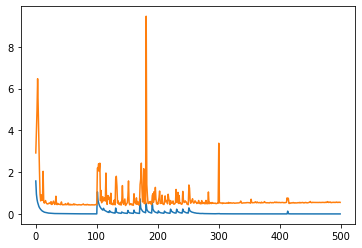

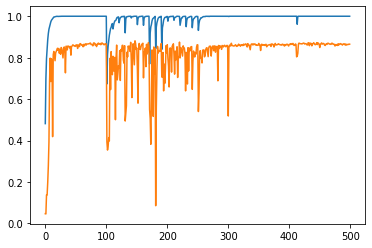

In [ ]:
print(hist_p.history)
import matplotlib.pyplot as plt
plt.plot(hist_p.history["loss"])
plt.plot(hist_p.history["val_loss"])
plt.show()

plt.plot(hist_p.history["accuracy"])
plt.plot(hist_p.history["val_accuracy"])
plt.show()

In [ ]:
print(hist_s.history)
import matplotlib.pyplot as plt
plt.plot(hist_s.history["loss"])
plt.plot(hist_s.history["val_loss"])
plt.show()


plt.plot(hist_s.history["accuracy"])
plt.plot(hist_s.history["val_accuracy"])
plt.show()

In [ ]:
simple_model_file = 'simple_model.h5'
tf.keras.models.save_model(model_simple, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_0.h5'
tf.keras.models.save_model(new_pruned_model_0, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_1.h5'
tf.keras.models.save_model(new_pruned_model_1, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_2.h5'
tf.keras.models.save_model(new_pruned_model_2, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_3.h5'
tf.keras.models.save_model(new_pruned_model_3, simple_model_file,
                        include_optimizer=False)
simple_model_file = 'pruned_4.h5'
tf.keras.models.save_model(new_pruned_model_4, simple_model_file,
                        include_optimizer=False)

In [ ]:
model1=Model(model_simple.input, model_simple.output)
model1=model_simple.layers[2].output

In [ ]:
out1=model1.predicte(X_test_50[0])

#Quatisation

In [ ]:
def quantModel(model, pathx):
  model_file="q_temp.h5"
  tf.keras.models.save_model(model, model_file,
                        include_optimizer=False)
  converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_file)

  converter.optimizations = [tf.compat.v1.lite.Optimize.OPTIMIZE_FOR_SIZE]

  tflite_quant_model = converter.convert()

  tflite_quant_model_file = pathx
  with open(tflite_quant_model_file, 'wb') as f:
    f.write(tflite_quant_model)


def eval_model(lite_file, x_test, y_test):
  interpreter = tf.compat.v1.lite.Interpreter(model_path=str(lite_file))
  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  total_seen = 0
  num_correct = 0
  for img, label in zip(x_test, y_test):
    inp = img.reshape((1, 50, 50, 3))
    total_seen += 1
    interpreter.set_tensor(input_index, inp)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if np.argmax(predictions) == np.argmax(label):
      num_correct += 1
  return float(num_correct) / float(total_seen)



In [ ]:
quantModel(model_simple, "lite_simple.tflite")
quantModel(new_pruned_model_0, "lite_0.tflite")
quantModel(new_pruned_model_1, "lite_1.tflite")
quantModel(new_pruned_model_2, "lite_2.tflite")
quantModel(new_pruned_model_3, "lite_3.tflite")

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp8qujgfo0/assets
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /tmp/tmp8qujgfo0/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_

INFO:tensorflow:Assets written to: /tmp/tmplrv08e5z/assets


INFO:tensorflow:Assets written to: /tmp/tmplrv08e5z/assets


INFO:tensorflow:Restoring parameters from /tmp/tmplrv08e5z/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmplrv08e5z/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_4_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_4_input


INFO:tensorflow: tensor name: serving_default_conv2d_4_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_4_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_6


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_6


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /tmp/tmplrv08e5z/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmplrv08e5z/variables/variables


INFO:tensorflow:Assets written to: /tmp/tmpi05n6vnm/assets


INFO:tensorflow:Assets written to: /tmp/tmpi05n6vnm/assets


INFO:tensorflow:Restoring parameters from /tmp/tmpi05n6vnm/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmpi05n6vnm/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_8_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_8_input


INFO:tensorflow: tensor name: serving_default_conv2d_8_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_8_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_7


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_7


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /tmp/tmpi05n6vnm/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmpi05n6vnm/variables/variables


INFO:tensorflow:Assets written to: /tmp/tmp3lwmqydp/assets


INFO:tensorflow:Assets written to: /tmp/tmp3lwmqydp/assets


INFO:tensorflow:Restoring parameters from /tmp/tmp3lwmqydp/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmp3lwmqydp/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_12_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_12_input


INFO:tensorflow: tensor name: serving_default_conv2d_12_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_12_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_8


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_8


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /tmp/tmp3lwmqydp/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmp3lwmqydp/variables/variables


INFO:tensorflow:Assets written to: /tmp/tmprrgydc82/assets


INFO:tensorflow:Assets written to: /tmp/tmprrgydc82/assets


INFO:tensorflow:Restoring parameters from /tmp/tmprrgydc82/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmprrgydc82/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_16_input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: conv2d_16_input


INFO:tensorflow: tensor name: serving_default_conv2d_16_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow: tensor name: serving_default_conv2d_16_input:0, shape: (-1, 50, 50, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_9


INFO:tensorflow:Tensor's key in saved_model's tensor_map: dense_9


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (-1, 13), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /tmp/tmprrgydc82/variables/variables


INFO:tensorflow:Restoring parameters from /tmp/tmprrgydc82/variables/variables


In [ ]:
print(eval_model("lite_simple.tflite", X_test_50, y_test))
print(eval_model("lite_0.tflite", X_test_50, y_test))
print(eval_model("lite_1.tflite", X_test_50, y_test))
print(eval_model("lite_2.tflite", X_test_50, y_test))
print(eval_model("lite_3.tflite", X_test_50, y_test))

0.8831985624438454
0.8616352201257862
0.862533692722372
0.7762803234501348
0.7232704402515723


#FLOPS

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras.backend as K
import numpy as np
def get_flops(model):
  model_file="for_flops.h5"
  tf.keras.models.save_model(model, model_file,
                        include_optimizer=False)
  run_meta = tf.compat.v1.RunMetadata()
  with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    net = load_model(model_file)
    x=np.ones([50,50,3])
    x_placeholder =  tf.compat.v1.placeholder(tf.float32, shape=(None,50,50,3))
    y = net(x_placeholder)


    #opts = tf.profiler.ProfileOptionBuilder.float_operation()
    opts=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation() 
    flops = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.compat.v1.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops, params.total_parameters

In [ ]:
compter=ModelProfiler()
w_n,w_p=compter.cuntPrunedWith(new_pruned_model)
print(w_n+w_p)

In [ ]:
s=get_flops(model_simple)
p0=get_flops(new_pruned_model_0)
p1=get_flops(new_pruned_model_1)
p2=get_flops(new_pruned_model_2)
p3=get_flops(new_pruned_model_3)
p4=get_flops(new_pruned_model_4)

In [ ]:
print(s)
print(p0)
print(p1)
print(p2)
print(p3)
print(p4)

In [ ]:
def printsize(f_model):
  print("Size of the model: %.2f Mb" 
      % (os.path.getsize(f_model) / float(2**20)))

printsize("simple_model.h5")
printsize("pruned_0.h5")
printsize("pruned_1.h5")
printsize("pruned_2.h5")
printsize("pruned_3.h5")
printsize("pruned_4.h5")

Size of the model: 2.93 Mb
Size of the model: 0.23 Mb
Size of the model: 0.17 Mb
Size of the model: 0.11 Mb
Size of the model: 0.08 Mb
Size of the model: 0.05 Mb


In [ ]:
def printsize(f_model):
  print("Size of the model: %.2f Mb" 
      % (os.path.getsize(f_model) / float(2**20)))

printsize("lite_simple.tflite")
printsize("lite_0.tflite")
printsize("lite_1.tflite")
printsize("lite_2.tflite")
printsize("lite_3.tflite")

Size of the model: 0.73 Mb
Size of the model: 0.06 Mb
Size of the model: 0.04 Mb
Size of the model: 0.03 Mb
Size of the model: 0.02 Mb
